/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/writhe.py:534: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 4 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(s, ax=ax, fraction=0.046, pad=0.04)
2025-10-09 17:11:21,126	INFO worker.py:1917 -- Started a local Ray instance.
/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/writhe.py:534: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 5 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(s, ax=ax, fraction=0.046, pad=0.04)
2025-10-09 17:11:26,876	INFO worker.py:1917 -- Started a local Ray instance.
/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/writhe.py:534: UserWarning: Adding colorbar to a different Figure <Figure size 1000x400 with 6 Axes> than <Figure size 640x480 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(s, ax=ax, fraction=0.046, pad=0.0

Text(0.5, 1.0, 'sum of abs(Wr)')

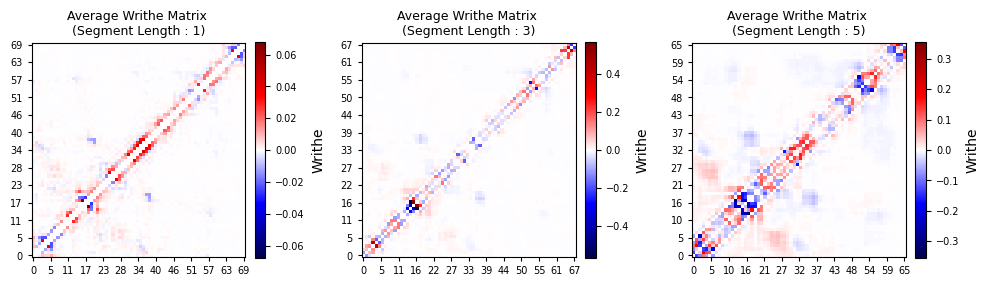

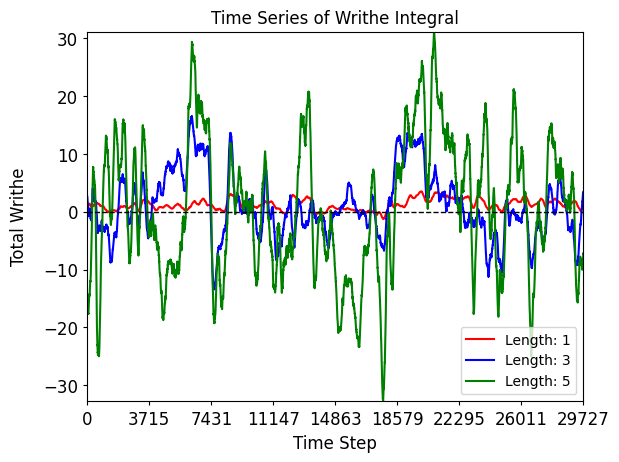

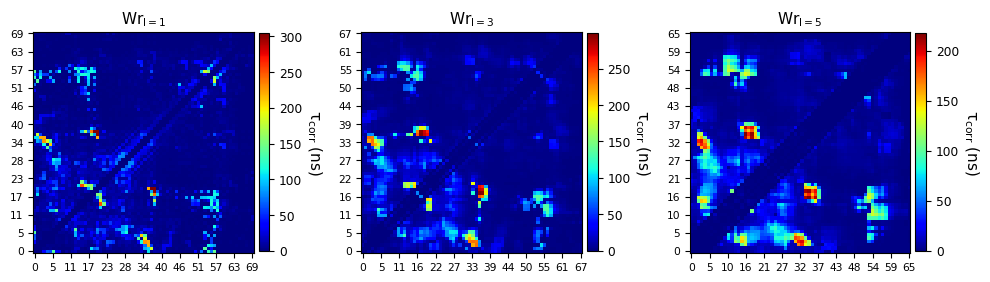

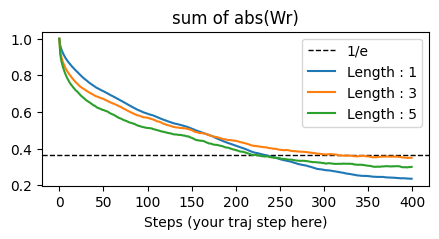

In [8]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import ray

from writhe_tools.writhe import Writhe, to_writhe_matrix
from writhe_tools.plots import plot_distance_matrix
from writhe_tools.utils import symbols


def acf(x):
    """
    Computes the autocorrelation function (ACF) of a 1D time series using FFT.

    Parameters:
    - x (np.ndarray): Input 1D signal.

    Returns:
    - acf (np.ndarray): The autocorrelation function.
    """
    N = len(x)
    x = x - np.mean(x)
    return np.fft.ifft(np.abs(np.fft.fft(x, n=2*N))**2).real[:N] / (N * np.var(x))

def get_time(acf, cutoff=np.exp(-1)):

    return np.sum(acf[:(acf <= cutoff).argmax() + 1])
    
@ray.remote
def get_acf_time(x, cutoff=np.exp(-1)):
    return get_time(acf(x), cutoff=np.exp(-1))


traj_file, pdb = '/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd', '/home/t/writhe/actr/actr.pdb'

lengths = [1,3,5]

xyz = md.load(traj_file, top=pdb,
              atom_indices=md.load(pdb).top.select("name CA")
              ).center_coordinates().xyz

writhe = Writhe(xyz)

# loop through to use class to plot stuff (not needed)
writhes = []
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
fig1, ax1 = plt.subplots(1,1, )

for l, ax, color in zip(lengths, axes.flat, ['red', 'blue', 'green']):
    features = writhe.compute_writhe(length=l)['writhe_features'] # stores result internally
    writhes.append(features)
    writhe.plot_writhe_matrix(ax=ax)
    writhe.plot_writhe_total(ax=ax1, window=250, color=color, **{'label':f'Length: {l}'})
    

fig.tight_layout()
ax1.legend()
ax1.set_title("Time Series of Writhe Integral")
ax1.axhline(y=0,
                linestyle='--',
                color='black',
                linewidth=1,
               )
    

# all the correlations (matrix)
correlation_times = [np.array(ray.get([get_acf_time.remote(i) for i in j.T])) for j in writhes]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for wr, l, ax in zip(correlation_times, lengths, axes.flat):
    plot_distance_matrix(to_writhe_matrix(wr, xyz.shape[1], l).squeeze() * 0.2,
                         cmap="jet",
                         ax=ax,
                         cbar_label=rf"{symbols('tau')}$_{{corr}}$ (ns)",
                         title=fr"$\text{{Wr}}_{{l={l}}}$",#Wr_{l=}length {l}",
                         font_scale=1.1,
                         aspect="equal",
                         label_stride=5,
                         xticks_rotation=0,
                        )
plt.tight_layout()


abs_sum_acfs = [acf(abs(i).sum(-1)) for i in writhes]

fig, axes = plt.subplots(1, 1, figsize=(5, 2))
axes.axhline(y=1/np.exp(1),
                linestyle='--',
                color='black',
                linewidth=1,
                label='1/e',
               )

for wr, l in zip(abs_sum_acfs, lengths):
    axes.plot(wr[:400],label= f"Length : {l}")
    
axes.legend()
axes.set_xlabel("Steps (your traj step here)")
axes.set_title('sum of abs(Wr)')



